### Introducing Optimization

we have:

* built the neural network
* passed data through it
* calculated the loss

now, we have to adjust the weights and biases to decrease the loss

a intuitive way of doing this would be to randomly change the weights, doing this until we have found the lowest loss. lets demonstrate this:

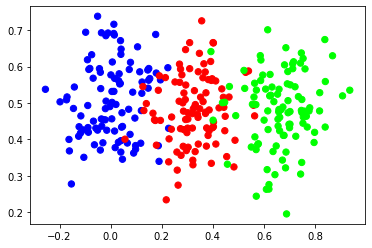

In [38]:
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import vertical_data

nnfs.init()

X, y = vertical_data(samples=100, classes=3)

plt.scatter(X[:,0], X[:,1], c=y, s=40, cmap='brg')
plt.show()

lets use this simple dataset for the neural network we have created:

this is first 5 samples in the dataset: 
 [[-0.15504293  0.35550597]
 [ 0.04173188  0.3789457 ]
 [-0.09443685  0.42113307]
 [ 0.02381032  0.6094638 ]
 [-0.1405963   0.52348214]] shape:  (300, 2)
this is the first 5 values in the y: 
 [0 0 0 0 0] shape:  (300,)


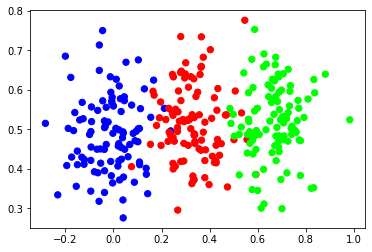

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import vertical_data

#creation of the Dense Layer Class
class Dense_Layer:
    def __init__(self, num_features, num_neurons):
        self.weights = np.random.randn(num_features, num_neurons)
        self.biases = np.zeros((1, num_neurons))

    def forward(self, samples):
        self.outputs = np.dot(samples, self.weights) + self.biases

class ReLU:
    def forward(self, inputs):
        self.outputs = np.maximum(0, inputs)

class SoftMax:
    def forward(self, inputs):
        #compute the exponentiated values for the inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        #compute the normalized values for the inputs
        self.outputs = exp_values / np.sum(exp_values, axis=1, keepdims=True) 

class CategoricalCrossEntropyLoss:
    def forward(self, y_pred, y_true):
        samples = len(y_pred)

        #clip the data using np.clipped
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        #if the target values is a one-hot vector:
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences =  np.sum(y_pred_clipped * y_true, axis=1)

        #sample losses
        neg_log = -np.log(correct_confidences)

        #average losses
        average_loss = np.mean(neg_log)
        return average_loss

#create the dataset
X, y = vertical_data(samples=100, classes=3)
print('this is first 5 samples in the dataset: \n', X[:5], 'shape: ', X.shape)
print('this is the first 5 values in the y: \n', y[:5], 'shape: ', y.shape)

plt.scatter(X[:,0], X[:,1], c=y, s=40, cmap='brg')
plt.show()

#create the model
dense1 = Dense_Layer(2, 3)
activation1 = ReLU()
dense2 = Dense_Layer(3, 3)
activation2 = SoftMax()

#create the loss function
loss_function = CategoricalCrossEntropyLoss()

helper variables to trach the best loss and the associated weights and biases:

In [40]:
lowest_loss = 999999 #some initial value
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

we have also initialized the loss to a large value and it will decrease when a new, lower loss is found.

We copied the weights and biases to ensure a full copy is made, instead of an reference to the object.

Now, lets iterate as many times as desired, pick random values for the weights and biases, and save the weights and biasses if they generate the lowest-seen loss

In [41]:
for iteration in range(10000):
    #generate a new set of weights for the iteration
    dense1.weights = 0.05 * np.random.randn(2, 3)
    dense1.biases = 0.05 * np.random.randn(1, 3)
    dense2.weights = 0.05 * np.random.randn(3, 3)
    dense2.biases = 0.05 * np.random.randn(1, 3)

    #perform a forward pass of the training data through this layer
    dense1.forward(X)
    activation1.forward(dense1.outputs)
    dense2.forward(activation1.outputs)
    activation2.forward(dense2.outputs)

    #perform a forward pass through the loss function, returns the loss.
    loss = loss_function.forward(activation2.outputs, y)

    #calculate the accuracy from the output of softmax and targets
    predictions = np.argmax(activation2.outputs, axis=1)
    accuracy = np.mean(predictions==y)

    #if loss is smaller, print and save weights and biases aside.
    if loss < lowest_loss:
        print('New set of weights found, iteration: ', iteration, 'loss: ', loss, 'acc:', accuracy)
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
        lowest_loss = loss


New set of weights found, iteration:  0 loss:  1.1016203 acc: 0.3333333333333333
New set of weights found, iteration:  1 loss:  1.1002508 acc: 0.3333333333333333
New set of weights found, iteration:  2 loss:  1.0992025 acc: 0.3333333333333333
New set of weights found, iteration:  3 loss:  1.0986239 acc: 0.3333333333333333
New set of weights found, iteration:  10 loss:  1.0984299 acc: 0.3333333333333333
New set of weights found, iteration:  22 loss:  1.0976521 acc: 0.36333333333333334
New set of weights found, iteration:  150 loss:  1.0974255 acc: 0.3333333333333333
New set of weights found, iteration:  874 loss:  1.0972673 acc: 0.3333333333333333
New set of weights found, iteration:  894 loss:  1.096895 acc: 0.3333333333333333
New set of weights found, iteration:  1036 loss:  1.095428 acc: 0.3333333333333333


As you can see, the loss falls, but not by that much. the accuracy did not improve.

Obviously, randomly searching for weight and bias combinations will take far too long, thus it does not appear to be a reliable method for minimizing the loss.

lets apply a fraction to each of the values to parameters. with this, the weights will be updates from what currently yields us the loqwest loss, instead of doing it randomly.

> if the adjustment decreases loss, we will make it the new point to adjust from. 

> if the loss instead increases due to the adjustment, then we revert to the previous point.

lets implement this:

this is first 5 samples in the dataset: 
 [[-0.05857731  0.45986405]
 [-0.03750004  0.5257617 ]
 [ 0.05391425  0.45462376]
 [-0.02924899  0.45212892]
 [ 0.04803258  0.58806276]] shape:  (300, 2)
this is the first 5 values in the y: 
 [0 0 0 0 0] shape:  (300,)


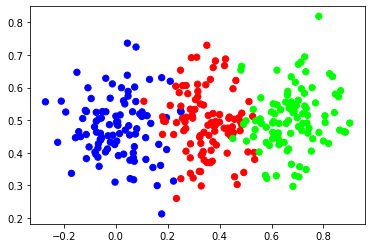

New set of weights found, iteration:  0 loss:  1.2677469 acc: 0.3333333333333333
New set of weights found, iteration:  1 loss:  1.2270933 acc: 0.3333333333333333
New set of weights found, iteration:  2 loss:  1.209631 acc: 0.4633333333333333
New set of weights found, iteration:  3 loss:  1.1964608 acc: 0.3333333333333333
New set of weights found, iteration:  5 loss:  1.1915107 acc: 0.3333333333333333
New set of weights found, iteration:  6 loss:  1.1702031 acc: 0.3333333333333333
New set of weights found, iteration:  9 loss:  1.1454073 acc: 0.3333333333333333
New set of weights found, iteration:  10 loss:  1.132507 acc: 0.3333333333333333
New set of weights found, iteration:  14 loss:  1.1063559 acc: 0.3333333333333333
New set of weights found, iteration:  15 loss:  1.0859183 acc: 0.3333333333333333
New set of weights found, iteration:  17 loss:  1.0856147 acc: 0.3333333333333333
New set of weights found, iteration:  21 loss:  1.0854529 acc: 0.3333333333333333
New set of weights found,

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import vertical_data

#creation of the Dense Layer Class
class Dense_Layer:
    def __init__(self, num_features, num_neurons):
        self.weights = np.random.randn(num_features, num_neurons)
        self.biases = np.zeros((1, num_neurons))

    def forward(self, samples):
        self.outputs = np.dot(samples, self.weights) + self.biases

class ReLU:
    def forward(self, inputs):
        self.outputs = np.maximum(0, inputs)

class SoftMax:
    def forward(self, inputs):
        #compute the exponentiated values for the inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        #compute the normalized values for the inputs
        self.outputs = exp_values / np.sum(exp_values, axis=1, keepdims=True) 

class CategoricalCrossEntropyLoss:
    def forward(self, y_pred, y_true):
        samples = len(y_pred)

        #clip the data using np.clipped
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        #if the target values is a one-hot vector:
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences =  np.sum(y_pred_clipped * y_true, axis=1)

        #sample losses
        neg_log = -np.log(correct_confidences)

        #average losses
        average_loss = np.mean(neg_log)
        return average_loss

#create the dataset
X, y = vertical_data(samples=100, classes=3)
print('this is first 5 samples in the dataset: \n', X[:5], 'shape: ', X.shape)
print('this is the first 5 values in the y: \n', y[:5], 'shape: ', y.shape)

plt.scatter(X[:,0], X[:,1], c=y, s=40, cmap='brg')
plt.show()

#create the model
dense1 = Dense_Layer(2, 3)
activation1 = ReLU()
dense2 = Dense_Layer(3, 3)
activation2 = SoftMax()

#create the loss function
loss_function = CategoricalCrossEntropyLoss()

#helper variables to track the best loss, and its associated weightsa and biases
lowest_loss = 999999 #some initial value
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

for iteration in range(100000):
    #update the weights with some small values
    dense1.weights += 0.05 * np.random.randn(2, 3)
    dense1.biases += 0.05 * np.random.randn(1, 3)
    dense2.weights += 0.05 * np.random.randn(3, 3)
    dense2.biases += 0.05 * np.random.randn(1, 3)

    #perform a forward pass of the training data through this layer
    dense1.forward(X)
    activation1.forward(dense1.outputs)
    dense2.forward(activation1.outputs)
    activation2.forward(dense2.outputs)

    #perform a forward pass through the loss function, returns the loss.
    loss = loss_function.forward(activation2.outputs, y)

    #calculate the accuracy from the output of softmax and targets
    predictions = np.argmax(activation2.outputs, axis=1)
    accuracy = np.mean(predictions==y)

    #if loss is smaller, print and save weights and biases aside.
    if loss < lowest_loss:
        print('New set of weights found, iteration: ', iteration, 'loss: ', loss, 'acc:', accuracy)
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
        lowest_loss = loss
    #revert weights and biases
    else:
        dense1.weights = best_dense1_weights.copy()
        dense1.biases = best_dense1_biases.copy()
        dense2.weights = best_dense2_weights.copy()
        dense2.biases = best_dense2_biases.copy() 


as you can see, the loss decreased and the accuracy increased significantly. Applying a fraction of random values actually leades to a result that we could almost call a solution.

lets now do this with the spiral_data dataset instead! (try to write the whole program yourself)

this is first 5 samples in the dataset: 
 [[ 0.          0.        ]
 [ 0.00071638  0.01007557]
 [ 0.01955939  0.00505487]
 [ 0.00579346  0.02974407]
 [-0.00252     0.04032538]] shape:  (300, 2)
this is the first 5 values in the y: 
 [0 0 0 0 0] shape:  (300,)


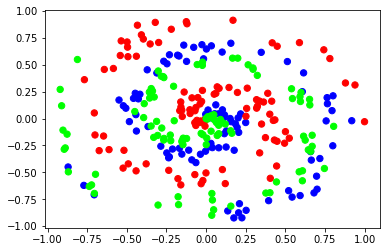

New set of weights found, iteration:  0 loss:  1.0999598931956684 acc: 0.3333333333333333
New set of weights found, iteration:  1 loss:  1.0992645223282513 acc: 0.3333333333333333
New set of weights found, iteration:  6 loss:  1.0991303148134588 acc: 0.3333333333333333
New set of weights found, iteration:  8 loss:  1.0985002517629887 acc: 0.32
New set of weights found, iteration:  10 loss:  1.0977838478894462 acc: 0.36333333333333334
New set of weights found, iteration:  16 loss:  1.0963418837682426 acc: 0.37666666666666665
New set of weights found, iteration:  20 loss:  1.0961919569608014 acc: 0.36333333333333334
New set of weights found, iteration:  22 loss:  1.0960831717415265 acc: 0.33666666666666667
New set of weights found, iteration:  24 loss:  1.0959408784609437 acc: 0.3933333333333333
New set of weights found, iteration:  25 loss:  1.0957262272858934 acc: 0.35333333333333333
New set of weights found, iteration:  26 loss:  1.0952695669988741 acc: 0.35333333333333333
New set of 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import spiral_data

#creation of the classes used for the neural network:
class Dense_Layer:
    def __init__(self, num_features, num_neurons):
        self.weights = 0.01 * np.random.randn(num_features, num_neurons)
        self.biases = np.zeros((1, num_neurons))

    def forward(self, samples):
        self.outputs = np.dot(samples, self.weights) + self.biases 

class ReLU:
    def forward(self, inputs):
        self.outputs = np.maximum(0, inputs)

class SoftMax:
    def forward(self, inputs):
        self.outputs = np.exp(inputs - np.max(inputs, axis=1, keepdims=True)) / np.sum(np.exp(inputs - np.max(inputs, axis=1, keepdims=True)), axis=1, keepdims=True) 

class CategoricalCrossEntropyLoss:
    def forward(self, y_pred, y_true):
        samples = len(y_pred)

        #clip the values:
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        #compute the confidences, depending on the shape of the one-hot target values
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences =  np.sum(y_pred_clipped * y_true, axis=1)

        #sample losses
        neg_log = -np.log(correct_confidences)

        #average loss
        average_loss = np.mean(neg_log)    
        return average_loss

#create the dataset
X, y = spiral_data(samples=100, classes=3)
print('this is first 5 samples in the dataset: \n', X[:5], 'shape: ', X.shape)
print('this is the first 5 values in the y: \n', y[:5], 'shape: ', y.shape)

plt.scatter(X[:,0], X[:,1], c=y, s=40, cmap='brg')
plt.show()

#create the model
dense1 = Dense_Layer(2, 3)
activation1 = ReLU()
dense2 = Dense_Layer(3, 3)
activation2 = SoftMax()

#create the loss function
loss_function = CategoricalCrossEntropyLoss()      

#helper variables to track the best loss, and its associated weightsa and biases
lowest_loss = 999999 #some initial value
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

for iteration in range(100000):
    #update the weights with some small values
    dense1.weights += 0.05 * np.random.randn(2, 3)
    dense1.biases += 0.05 * np.random.randn(1, 3)
    dense2.weights += 0.05 * np.random.randn(3, 3)
    dense2.biases += 0.05 * np.random.randn(1, 3)

    #perform a forward pass of the training data through this layer
    dense1.forward(X)
    activation1.forward(dense1.outputs)
    dense2.forward(activation1.outputs)
    activation2.forward(dense2.outputs)

    #perform a forward pass through the loss function, returns the loss.
    loss = loss_function.forward(activation2.outputs, y)

    #calculate the accuracy from the output of softmax and targets
    predictions = np.argmax(activation2.outputs, axis=1)
    accuracy = np.mean(predictions==y)

    #if loss is smaller, print and save weights and biases aside.
    if loss < lowest_loss:
        print('New set of weights found, iteration: ', iteration, 'loss: ', loss, 'acc:', accuracy)
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
        lowest_loss = loss
    #revert weights and biases
    else:
        dense1.weights = best_dense1_weights.copy()
        dense1.biases = best_dense1_biases.copy()
        dense2.weights = best_dense2_weights.copy()
        dense2.biases = best_dense2_biases.copy() 